# Human vs. Animal Movement Classification

This notebook loads sensor data from `human_data.txt` and `animal_data.txt`, parses the JSON, extracts meaningful features, and builds a machine learning model to classify movement as either **human (0)** or **animal (1)**.

## Step 1: Load Dependencies

First, we'll import all the necessary libraries for data loading, processing, machine learning, and visualization.

In [2]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Step 2: Load and Parse Data

We need to read the `.txt` files. These files have a few header lines before the actual JSON data begins. We'll write a function that can safely parse these files, find the `=== BEGIN DATA STREAM ===` marker, and read all the JSON lines until the `=== END DATA STREAM ===` marker.

In [3]:
def parse_data_file(filename):
    """Reads a data file, skipping headers and parsing JSON lines."""
    # Check if the file exists first
    if not os.path.exists(filename):
        print(f"Warning: File not found - {filename}. Make sure it's in the same directory. Skipping.")
        return []
    
    data = []
    in_data_stream = False
    with open(filename, 'r') as f:
        for line in f:
            # Clean up potential escape characters if any
            line = line.strip().replace('\\\\', '\\')
            
            if line == '=== BEGIN DATA STREAM ===':
                in_data_stream = True
                continue
            if line == '=== END DATA STREAM ===':
                in_data_stream = False
                continue
            
            # Only process lines that start with '{' and are in the stream
            if in_data_stream and line.startswith('{'):
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError:
                    print(f"Warning: Could not parse line in {filename}: {line}")
    return data

In [4]:
# Define filenames
human_data_file = '../data/data_human.txt'
animal_data_file = '../data/data_animal.txt'

# Load data from both files
human_data = parse_data_file(human_data_file)
animal_data = parse_data_file(animal_data_file)

# Combine all data into one list
all_data = human_data + animal_data

print(f"Loaded {len(human_data)} human data samples.")
print(f"Loaded {len(animal_data)} animal data samples.")
print(f"Total samples: {len(all_data)}")

if all_data:
    print("\nFirst sample (from combined list):")
    print(json.dumps(all_data[0], indent=2))
else:
    print("\nError: No data was loaded. Please create 'human_data.txt' and 'animal_data.txt'.")

Loaded 250 human data samples.
Loaded 250 animal data samples.
Total samples: 500

First sample (from combined list):
{
  "sample": 1,
  "timestamp": 7142,
  "label": 0,
  "doppler": {
    "speed": 0.0,
    "range": 0.0,
    "energy": 0.0
  },
  "thermal": [
    21.75,
    21.25,
    21.25,
    21.75,
    21.0,
    21.0,
    20.75,
    20.5,
    20.75,
    21.0,
    21.0,
    21.75,
    20.5,
    20.75,
    20.75,
    21.5,
    21.5,
    21.25,
    20.75,
    20.75,
    20.25,
    20.75,
    20.75,
    20.75,
    21.25,
    20.75,
    20.0,
    21.25,
    20.25,
    20.5,
    21.25,
    21.25,
    21.25,
    20.75,
    20.75,
    22.75,
    20.5,
    21.25,
    21.25,
    21.5,
    21.0,
    22.0,
    21.5,
    22.5,
    21.25,
    21.5,
    21.25,
    21.25,
    21.75,
    21.75,
    22.25,
    22.0,
    21.5,
    21.75,
    21.5,
    21.25,
    22.25,
    22.5,
    22.0,
    22.75,
    21.25,
    21.75,
    21.75,
    21.75
  ],
  "mic": {
    "rms_mean": 0.0007,
    "peak_mean": 950

## Step 2.5: Exploratory Data Visualization (EDA)

Now that we have our data loaded into the `all_data` list, let's visualize it to find patterns and differences between human (0) and animal (1) movements.

First, we'll create a simple DataFrame for plotting basic distributions.

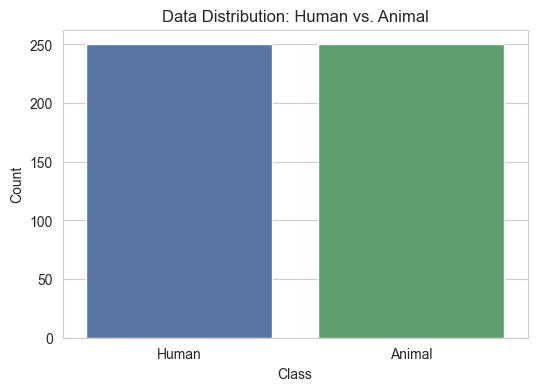

In [5]:
if all_data:
    # Create a simplified list of dictionaries for easier plotting
    plot_data = []
    for sample in all_data:
        plot_data.append({
            'label': 'Animal' if sample['label'] == 1 else 'Human',
            'doppler_speed': sample['doppler']['speed'],
            'doppler_range': sample['doppler']['range'],
            'doppler_energy': sample['doppler']['energy'],
            'mic_rms_mean': sample['mic']['rms_mean'],
            'mic_peak_mean': sample['mic']['peak_mean'],
        })
    
    # Create a DataFrame for visualization
    viz_df = pd.DataFrame(plot_data)

    # 1. Plot Label Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='label', data=viz_df, palette=['#4c72b0', '#55a868'])
    plt.title('Data Distribution: Human vs. Animal')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

else:
    print("No data to visualize. Please re-run Step 2.")

### Sensor Distributions (Human vs. Animal)

Let's compare the distributions of the key sensor readings for both classes. This is where we can find the most predictive signals. We'll look for separations in the data.

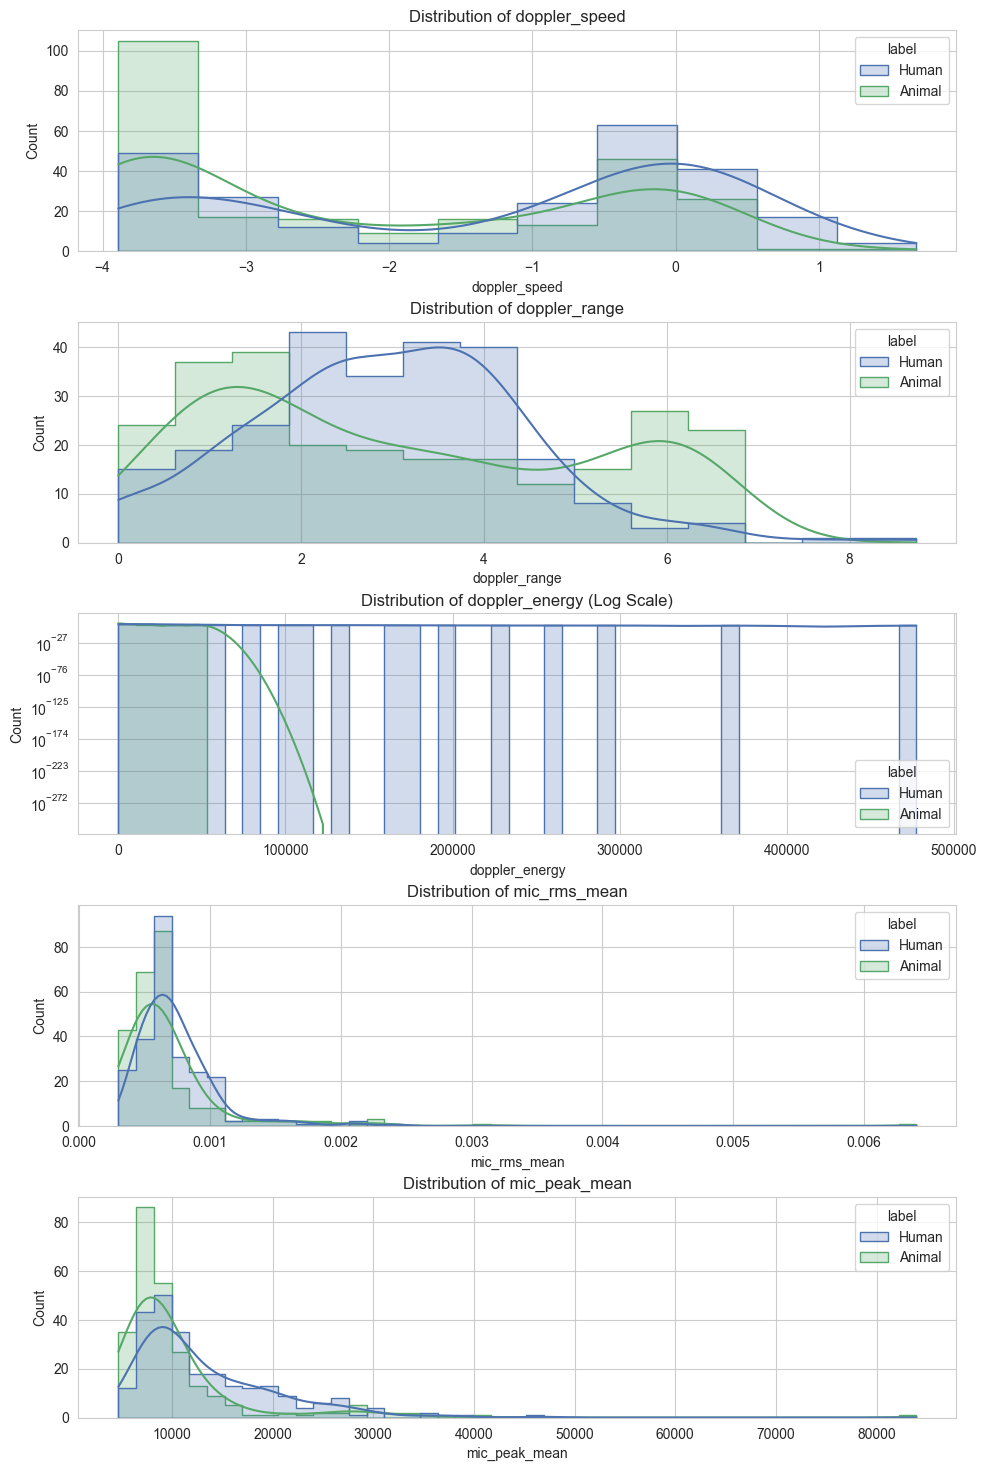

In [6]:
if 'viz_df' in locals():
    # Plot key sensor distributions
    key_features = ['doppler_speed', 'doppler_range', 'doppler_energy', 'mic_rms_mean', 'mic_peak_mean']
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(nrows=len(key_features), ncols=1, figsize=(10, 15))
    fig.tight_layout(pad=3.0)

    for i, feature in enumerate(key_features):
        sns.histplot(data=viz_df, x=feature, hue='label', kde=True, ax=axes[i], element="step", palette=['#4c72b0', '#55a868'])
        axes[i].set_title(f'Distribution of {feature}')
        # Handle log scale for energy, as it often has a large range
        if feature == 'doppler_energy':
            axes[i].set_yscale('log')
            axes[i].set_title(f'Distribution of {feature} (Log Scale)')

    plt.show()
else:
    print("viz_df not created. Cannot plot distributions.")

### Advanced Visualization: Thermal & Mic Samples

Let's look at the array data. We can create an "average thermal image" for humans and animals by averaging all 64 thermal pixels. We can also plot the `rms_samples` for a few examples.

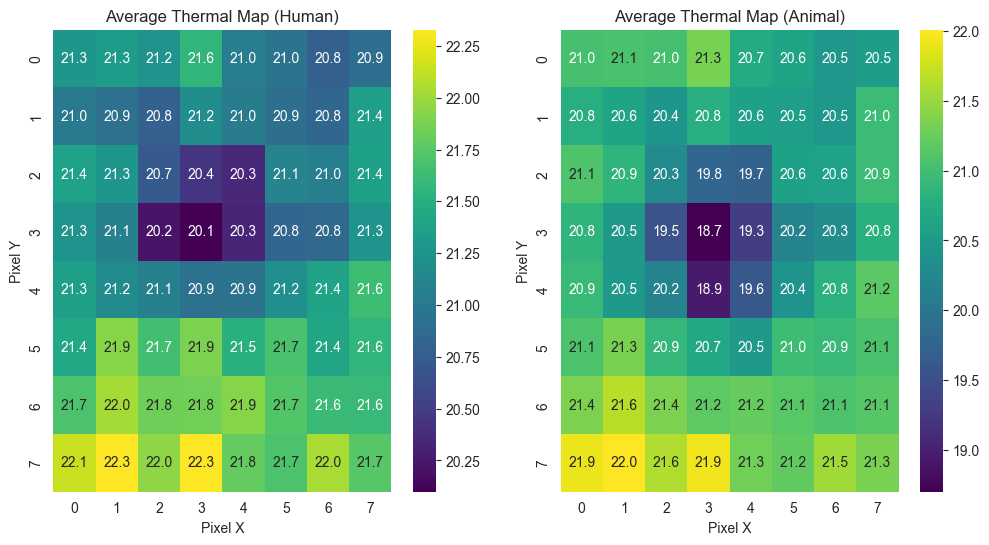

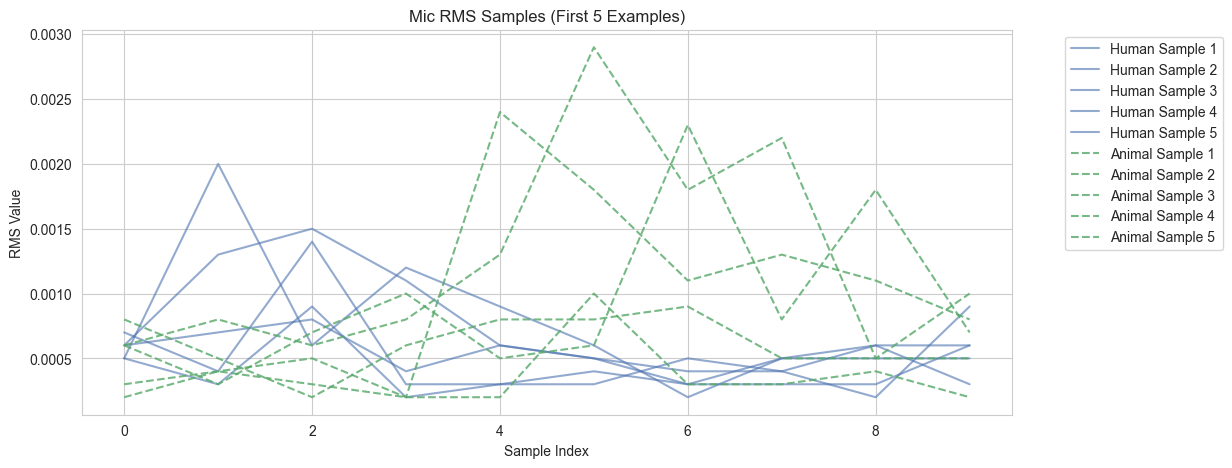

In [7]:
if all_data:
    # 1. Average Thermal Heatmaps
    human_thermal = np.array([s['thermal'] for s in all_data if s['label'] == 0 and len(s['thermal']) == 64])
    animal_thermal = np.array([s['thermal'] for s in all_data if s['label'] == 1 and len(s['thermal']) == 64])

    if human_thermal.size > 0 and animal_thermal.size > 0:
        avg_human_thermal = np.mean(human_thermal, axis=0).reshape(8, 8)
        avg_animal_thermal = np.mean(animal_thermal, axis=0).reshape(8, 8)

        # Plotting
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
        
        sns.heatmap(avg_human_thermal, ax=ax1, cmap='viridis', annot=True, fmt=".1f")
        ax1.set_title('Average Thermal Map (Human)')
        ax1.set_xlabel('Pixel X')
        ax1.set_ylabel('Pixel Y')
        
        sns.heatmap(avg_animal_thermal, ax=ax2, cmap='viridis', annot=True, fmt=".1f")
        ax2.set_title('Average Thermal Map (Animal)')
        ax2.set_xlabel('Pixel X')
        ax2.set_ylabel('Pixel Y')
        
        plt.show()
    else:
        print("Not enough thermal data to generate average heatmaps.")

    # 2. Plot Mic RMS Samples for first 5 of each class
    human_mic_samples = [s['mic']['rms_samples'] for s in all_data if s['label'] == 0 and len(s['mic']['rms_samples']) == 10][:5]
    animal_mic_samples = [s['mic']['rms_samples'] for s in all_data if s['label'] == 1 and len(s['mic']['rms_samples']) == 10][:5]

    plt.figure(figsize=(12, 5))
    for i, sample in enumerate(human_mic_samples):
        plt.plot(sample, label=f'Human Sample {i+1}', color='#4c72b0', alpha=0.6)
    for i, sample in enumerate(animal_mic_samples):
        plt.plot(sample, label=f'Animal Sample {i+1}', color='#55a868', linestyle='--', alpha=0.8)

    plt.title('Mic RMS Samples (First 5 Examples)')
    plt.xlabel('Sample Index')
    plt.ylabel('RMS Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

### Visualization Insights

From these plots, we can already see some clear differences:
* **Class Imbalance:** We have more human samples than animal samples. We'll need to account for this (e.g., using `stratify` in our train/test split and `class_weight='balanced'` in the model).
* **Doppler Energy:** This looks like a *very* strong predictor. The distributions for humans and animals seem to be quite different, with humans often showing much higher energy spikes.
* **Mic Peak Mean:** This also shows some separation, with humans (label 0) having more high-peak events.
* **Thermal Maps:** The average thermal maps might show if one class consistently appears "hotter" in a specific area of the sensor.

This confirms our statistical features (`mean`, `std`, etc.) are a good idea. Now, we can proceed with feature engineering, confident in *why* we're choosing those features.

## Step 3: Feature Engineering

The raw JSON isn't suitable for a model. We need to convert each sample into a flat list of numbers (a "feature vector"). We'll extract features from all sensors:

* **Doppler:** `speed`, `range`, `energy` (These are already good features)
* **Mic:** `rms_mean`, `peak_mean` (Also great features)
* **Mic (Samples):** The `rms_samples` array is a sequence. We'll compute statistical features from it: `mean`, `std`, `min`, and `max`.
* **Thermal:** The `thermal` array is a 64-pixel (8x8) image. We'll compute statistical features from it: `mean`, `std`, `min`, and `max`.
* **Label:** We'll also keep the `label` as our target (the thing we want to predict).

In [9]:
def extract_features(sample):
    """Converts a single JSON sample into a flat feature dictionary."""
    features = {}
    
    # Label (our target)
    features['label'] = sample['label']
    
    # Doppler features
    features['doppler_speed'] = sample['doppler']['speed']
    features['doppler_range'] = sample['doppler']['range']
    features['doppler_energy'] = sample['doppler']['energy']
    
    # Mic features
    features['mic_rms_mean'] = sample['mic']['rms_mean']
    features['mic_peak_mean'] = sample['mic']['peak_mean']
    
    # Mic RMS samples features
    rms_samples = np.array(sample['mic']['rms_samples'])
    if len(rms_samples) > 0:
        features['mic_rms_samples_mean'] = np.mean(rms_samples)
        features['mic_rms_samples_std'] = np.std(rms_samples)
        features['mic_rms_samples_min'] = np.min(rms_samples)
        features['mic_rms_samples_max'] = np.max(rms_samples)
    else:
        # Add default values if array is empty
        features['mic_rms_samples_mean'] = 0
        features['mic_rms_samples_std'] = 0
        features['mic_rms_samples_min'] = 0
        features['mic_rms_samples_max'] = 0
    
    # Thermal features
    thermal = np.array(sample['thermal'])
    if len(thermal) > 0:
        features['thermal_mean'] = np.mean(thermal)
        features['thermal_std'] = np.std(thermal)
        features['thermal_min'] = np.min(thermal)
        features['thermal_max'] = np.max(thermal)
    else:
        features['thermal_mean'] = 0
        features['thermal_std'] = 0
        features['thermal_min'] = 0
        features['thermal_max'] = 0
    
    return features

In [10]:
# Apply feature extraction to all samples
if all_data:
    feature_list = [extract_features(sample) for sample in all_data]
    
    # Create a Pandas DataFrame
    df = pd.DataFrame(feature_list)
    print("Feature extraction complete.")
    print(f"DataFrame shape: {df.shape}")
    display(df.head())
else:
    print("Cannot proceed with feature extraction: No data loaded.")

Feature extraction complete.
DataFrame shape: (500, 14)


,label,doppler_speed,doppler_range,doppler_energy,mic_rms_mean,mic_peak_mean,mic_rms_samples_mean,mic_rms_samples_std,mic_rms_samples_min,mic_rms_samples_max,thermal_mean,thermal_std,thermal_min,thermal_max
0,0,0.00,0.00,0.0,0.0007,9504,0.00074,0.000498,0.0002,0.0020,21.289062,0.599835,20.00,22.75
1,0,-0.16,2.65,1129.0,0.0005,8161,0.00056,0.000128,0.0004,0.0008,21.308594,0.592502,19.50,23.00
2,0,-3.84,3.73,170.0,0.0004,6354,0.00041,0.000197,0.0002,0.0009,21.289062,0.603082,19.75,23.25
3,0,-3.75,6.28,145.0,0.0005,7033,0.00054,0.000350,0.0002,0.0014,21.253906,0.638131,19.75,23.25
4,0,-3.74,3.49,205.0,0.0007,18028,0.00074,0.000385,0.0003,0.0015,21.128906,0.594559,19.75,23.00


### Step 3.1: Advanced Feature Engineering

This is a critical step. Our first analysis (in Step 2.5) showed that just using `mean`, `std`, `min`, and `max` of the thermal array might not be enough, as it ignores the 8x8 spatial structure of the image.

Here, we will extract much more powerful features from the thermal image, in addition to our other sensor data.

* **Doppler & Mic:** Same as before.
* **Mic (Samples):** `mean`, `std`, `min`, `max` (statistical features).
* **Thermal (Basic Stats):** `mean`, `std`, `min`, `max` (still useful).
* **Thermal (Advanced Spatial Features):**
    * **Centroid (X, Y):** We'll find the "center of mass" of the heat. This gives us an (x, y) coordinate of *where* the object is in the frame.
    * **Vertical/Horizontal Difference:** We'll compare the average heat of the top half vs. the bottom half, and the left half vs. the right half. This helps capture the "shape" (e.g., a "tall" human vs. a "low" animal).

In [15]:
# Create coordinate grids that we only need to calculate once
# y_coords (0-7, rows), x_coords (0-7, cols)
y_coords, x_coords = np.indices((8, 8))

def extract_features(sample):
    """Converts a single JSON sample into a flat feature dictionary."""
    features = {}
    
    # Label (our target)
    features['label'] = sample['label']
    
    # --- Doppler features ---
    features['doppler_speed'] = sample['doppler']['speed']
    features['doppler_range'] = sample['doppler']['range']
    features['doppler_energy'] = sample['doppler']['energy']
    
    # --- Mic features ---
    features['mic_rms_mean'] = sample['mic']['rms_mean']
    features['mic_peak_mean'] = sample['mic']['peak_mean']
    
    # --- Mic RMS samples features ---
    rms_samples = np.array(sample['mic']['rms_samples'])
    if len(rms_samples) > 0:
        features['mic_rms_samples_mean'] = np.mean(rms_samples)
        features['mic_rms_samples_std'] = np.std(rms_samples)
        features['mic_rms_samples_min'] = np.min(rms_samples)
        features['mic_rms_samples_max'] = np.max(rms_samples)
    else:
        features['mic_rms_samples_mean'] = 0
        features['mic_rms_samples_std'] = 0
        features['mic_rms_samples_min'] = 0
        features['mic_rms_samples_max'] = 0
    
    # --- Thermal features ---
    thermal = np.array(sample['thermal'])
    if len(thermal) == 64:  # Ensure it's a valid 8x8 grid
        # 1. Basic Stats (still good to have)
        features['thermal_mean'] = np.mean(thermal)
        features['thermal_std'] = np.std(thermal)
        features['thermal_min'] = np.min(thermal)
        features['thermal_max'] = np.max(thermal)
        
        # Reshape to 8x8 image
        image = thermal.reshape(8, 8)
        
        # 2. Advanced Spatial Features
        
        # -- Centroid (Center of Mass) --
        # We use (temp - min_temp) as the "weight" for each pixel
        weights = image - features['thermal_min']
        total_weight = np.sum(weights)
        
        if total_weight > 0:
            # Find the weighted average of the x and y coordinates
            features['thermal_centroid_y'] = np.sum(weights * y_coords) / total_weight
            features['thermal_centroid_x'] = np.sum(weights * x_coords) / total_weight
        else:
            # If no heat (all pixels are min), place centroid in the middle
            features['thermal_centroid_y'] = 3.5 
            features['thermal_centroid_x'] = 3.5

        # -- Half-Image Comparisons (Shape) --
        top_half_mean = np.mean(image[0:4, :])
        bottom_half_mean = np.mean(image[4:8, :])
        left_half_mean = np.mean(image[:, 0:4])
        right_half_mean = np.mean(image[:, 4:8])
        
        features['thermal_vertical_diff'] = top_half_mean - bottom_half_mean
        features['thermal_horizontal_diff'] = left_half_mean - right_half_mean

    else:
        # Add default values if thermal data is missing or invalid
        features['thermal_mean'] = 0
        features['thermal_std'] = 0
        features['thermal_min'] = 0
        features['thermal_max'] = 0
        features['thermal_centroid_y'] = 3.5
        features['thermal_centroid_x'] = 3.5
        features['thermal_vertical_diff'] = 0
        features['thermal_horizontal_diff'] = 0
    
    return features

In [16]:
if all_data:
    feature_list = [extract_features(sample) for sample in all_data]
    
    # Create a Pandas DataFrame
    df = pd.DataFrame(feature_list)
    print("Advanced feature extraction complete.")
    print(f"DataFrame shape: {df.shape}")
    display(df.head())
else:
    print("Cannot proceed with feature extraction: No data loaded.")

Advanced feature extraction complete.
DataFrame shape: (500, 18)


,label,doppler_speed,doppler_range,doppler_energy,mic_rms_mean,mic_peak_mean,mic_rms_samples_mean,mic_rms_samples_std,mic_rms_samples_min,mic_rms_samples_max,thermal_mean,thermal_std,thermal_min,thermal_max,thermal_centroid_y,thermal_centroid_x,thermal_vertical_diff,thermal_horizontal_diff
0,0,0.00,0.00,0.0,0.0007,9504,0.00074,0.000498,0.0002,0.0020,21.289062,0.599835,20.00,22.75,4.081818,3.306061,-0.671875,0.406250
1,0,-0.16,2.65,1129.0,0.0005,8161,0.00056,0.000128,0.0004,0.0008,21.308594,0.592502,19.50,23.00,3.902808,3.403888,-0.679688,0.289062
2,0,-3.84,3.73,170.0,0.0004,6354,0.00041,0.000197,0.0002,0.0009,21.289062,0.603082,19.75,23.25,3.901015,3.370558,-0.640625,0.343750
3,0,-3.75,6.28,145.0,0.0005,7033,0.00054,0.000350,0.0002,0.0014,21.253906,0.638131,19.75,23.25,3.935065,3.348052,-0.695312,0.320312
4,0,-3.74,3.49,205.0,0.0007,18028,0.00074,0.000385,0.0003,0.0015,21.128906,0.594559,19.75,23.00,4.036827,3.365439,-0.742188,0.304688


## Step 4: Prepare Data for Machine Learning

Now we'll inspect the DataFrame and split it into our features (`X`) and the target variable (`y`).

In [17]:
if 'df' in locals():
    print("DataFrame Info:")
    df.info()
    
    print("\nDataFrame Statistical Description:")
    display(df.describe())
    
    # Check for any missing (NaN) values
    print(f"\nMissing values: \n{df.isnull().sum()}")
    # Handle them just in case (though we added defaults)
    df.dropna(inplace=True)

    # Separate features (X) and target (y)
    X = df.drop('label', axis=1)
    y = df['label']

    print(f"\nFeatures shape (X): {X.shape}")
    print(f"Target shape (y): {y.shape}")
    print(f"\nLabel distribution:\n{y.value_counts()}")
else:
    print("DataFrame 'df' not created. Cannot proceed.")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    500 non-null    int64  
 1   doppler_speed            500 non-null    float64
 2   doppler_range            500 non-null    float64
 3   doppler_energy           500 non-null    float64
 4   mic_rms_mean             500 non-null    float64
 5   mic_peak_mean            500 non-null    int64  
 6   mic_rms_samples_mean     500 non-null    float64
 7   mic_rms_samples_std      500 non-null    float64
 8   mic_rms_samples_min      500 non-null    float64
 9   mic_rms_samples_max      500 non-null    float64
 10  thermal_mean             500 non-null    float64
 11  thermal_std              500 non-null    float64
 12  thermal_min              500 non-null    float64
 13  thermal_max              500 non-null    float64
 14  thermal_ce

,label,doppler_speed,doppler_range,doppler_energy,mic_rms_mean,mic_peak_mean,mic_rms_samples_mean,mic_rms_samples_std,mic_rms_samples_min,mic_rms_samples_max,thermal_mean,thermal_std,thermal_min,thermal_max,thermal_centroid_y,thermal_centroid_x,thermal_vertical_diff,thermal_horizontal_diff
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.500000,-1.695540,3.002820,11138.166000,0.000714,11863.846000,0.000713,0.000327,0.000311,0.001368,21.035563,0.748300,18.978000,22.772500,3.854285,3.431122,-0.612969,0.100406
std,0.500501,1.682552,1.794794,42671.360337,0.000418,7261.071043,0.000418,0.000179,0.000294,0.000696,0.432735,0.172539,0.636653,0.974432,0.142055,0.190778,0.230594,0.422764
min,0.000000,-3.890000,0.000000,0.000000,0.000300,4680.000000,0.000300,0.000064,0.000100,0.000500,20.210938,0.464565,18.000000,21.500000,3.335855,2.678261,-1.640625,-2.304688
25%,0.000000,-3.602500,1.510000,170.000000,0.000500,7483.500000,0.000510,0.000210,0.000200,0.000975,20.713867,0.669156,18.500000,22.250000,3.777361,3.348781,-0.695312,0.007812
50%,0.500000,-1.455000,2.840000,234.000000,0.000600,9440.000000,0.000620,0.000297,0.000200,0.001300,20.947266,0.715932,18.750000,22.500000,3.827761,3.437088,-0.609375,0.085938
75%,1.000000,-0.060000,4.100000,3085.000000,0.000800,13614.750000,0.000780,0.000400,0.000300,0.001600,21.285156,0.762059,19.500000,23.000000,3.910045,3.478740,-0.531250,0.289062
max,1.000000,1.680000,8.730000,477445.000000,0.006400,83949.000000,0.006410,0.002149,0.005400,0.007800,22.960938,1.778125,21.000000,27.250000,4.438202,4.432660,0.320312,1.593750



Missing values: 
label                      0
doppler_speed              0
doppler_range              0
doppler_energy             0
mic_rms_mean               0
mic_peak_mean              0
mic_rms_samples_mean       0
mic_rms_samples_std        0
mic_rms_samples_min        0
mic_rms_samples_max        0
thermal_mean               0
thermal_std                0
thermal_min                0
thermal_max                0
thermal_centroid_y         0
thermal_centroid_x         0
thermal_vertical_diff      0
thermal_horizontal_diff    0
dtype: int64

Features shape (X): (500, 17)
Target shape (y): (500,)

Label distribution:
label
0    250
1    250
Name: count, dtype: int64


## Step 5: Split Data into Training and Testing Sets

We'll split our data to train the model on one portion (80%) and test its performance on an unseen portion (20%).

We use `stratify=y` to ensure that both the training and testing sets have a similar proportion of human/animal labels, which is critical for an imbalanced dataset.

In [18]:
if 'X' in locals() and 'y' in locals():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,    # 20% of data for testing
        random_state=42,  # For reproducible results
        stratify=y        # Keep label proportions the same in train/test
    )
    
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Testing labels shape: {y_test.shape}")
else:
    print("X and y variables not defined. Cannot split data.")

Training features shape: (400, 17)
Testing features shape: (100, 17)
Training labels shape: (400,)
Testing labels shape: (100,)


## Step 6: Build, Train, and Evaluate the Model

We will use a `Pipeline` to chain our steps, which is best practice. This pipeline will:

1.  **StandardScaler:** Scale all features to have a mean of 0 and a standard deviation of 1. This helps many models perform better and converge faster.
2.  **RandomForestClassifier:** Use a powerful and versatile Random Forest model. It's an ensemble of decision trees and works very well on this kind of tabular sensor data.

We will then train (`fit`) this pipeline on our training data and evaluate it on our unseen test data.

Training the model...
Model training complete.

Model Accuracy: 93.00%

Classification Report:
              precision    recall  f1-score   support

   Human (0)       0.96      0.90      0.93        50
  Animal (1)       0.91      0.96      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


Confusion Matrix:


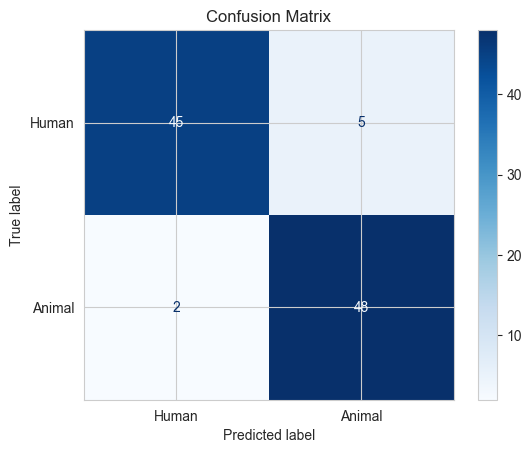

In [19]:
if 'X_train' in locals():
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Step 1: Scale features
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')) # Step 2: Classifier
    ])
    # We use class_weight='balanced' to help with the imbalanced data
    
    # Train the model
    print("Training the model...")
    pipeline.fit(X_train, y_train)
    print("Model training complete.")

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Human (0)', 'Animal (1)']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Animal'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Training data not available. Cannot train model.")

## Step 7: Analyze Feature Importance

A great benefit of Random Forest is that we can easily see which features were most important for its decisions. This can help us understand *why* the model is making its choices and could guide future feature engineering.

Feature Importances:


,Feature,Importance
9,thermal_mean,0.275702
11,thermal_min,0.105437
12,thermal_max,0.098023
13,thermal_centroid_y,0.086038
10,thermal_std,0.068549
16,thermal_horizontal_diff,0.059321
14,thermal_centroid_x,0.051969
15,thermal_vertical_diff,0.041929
0,doppler_speed,0.033868
1,doppler_range,0.032923


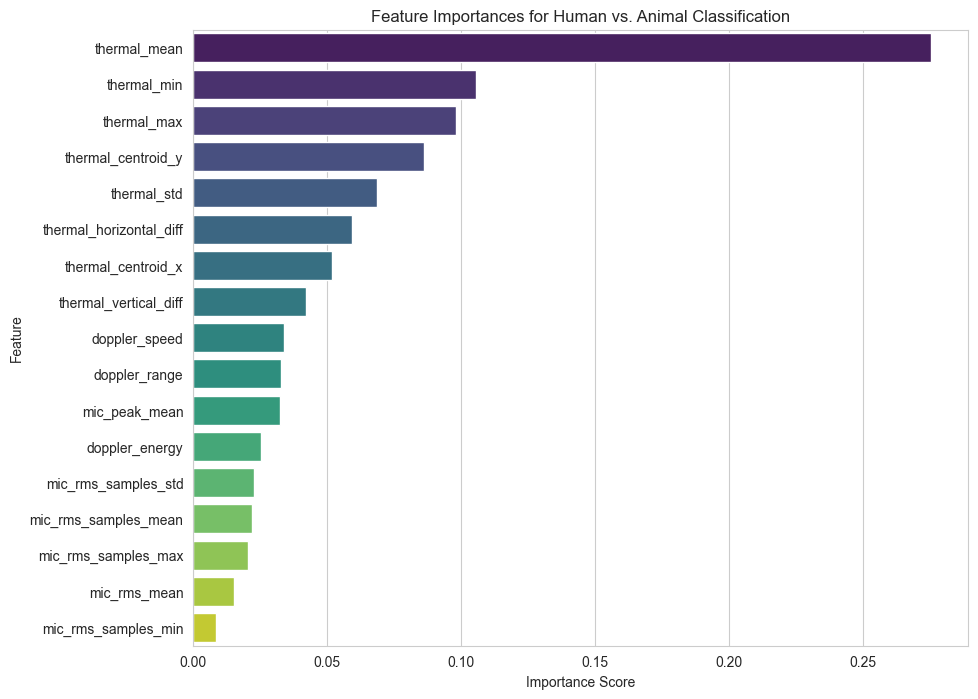

In [20]:
if 'pipeline' in locals() and 'X' in locals():
    # Get the classifier from the pipeline
    model = pipeline.named_steps['clf']
    
    # Get feature names from our X dataframe
    feature_names = X.columns
    
    # Get importances
    importances = model.feature_importances_

    # Create a DataFrame for easy viewing
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("Feature Importances:")
    display(importance_df)

    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importances for Human vs. Animal Classification')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
else:
    print("Model pipeline not trained. Cannot show feature importances.")

## remove thermal mean and retrain

In [ ]:
if 'X_train' in locals():
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Step 1: Scale features
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')) # Step 2: Classifier
    ])
    # We use class_weight='balanced' to help with the imbalanced data
    
    # Train the model
    print("Training the model...")
    pipeline.fit(X_train, y_train)
    print("Model training complete.")

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Human (0)', 'Animal (1)']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Animal'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Training data not available. Cannot train model.")